<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/8_stat_oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 20th May, 2021
Myfolder: 
Ref Kaggle:
   https://www.kaggle.com/c/statoil-iceberg-classifier-challenge

Good examples:
    https://github.com/Microsoft/LightGBM/tree/master/examples/python-guide

Ref: PCA vs TruncatedSVD
   https://stats.stackexchange.com/questions/239481/difference-between-scikit-learn-implementations-of-pca-and-truncatedsvd
   
Evaluation: For each id in the test set, you
            must predict the probability that
            the image contains an iceberg or
            a ship (a number between 0 and 1).

Objectuves:
            1. Learn working of lightgbm
            2. lightgbm
            3. Singular Value Decomposition
            4. Cross-validation in python
            5. Learning curves
            6. Feature importance
            7. Bayesian optimization
            8. Bayesian optimization using skoptimize
               (For Bayesian optimization using hyperopt-sklearn
		see folder 16.hyperopt. This method does not use
	 	Gaussian Processes to search for next hyperparameter
		point.)


Further study examples:
    https://github.com/Microsoft/LightGBM/tree/master/examples/python-guide

"""

## Lightgbm

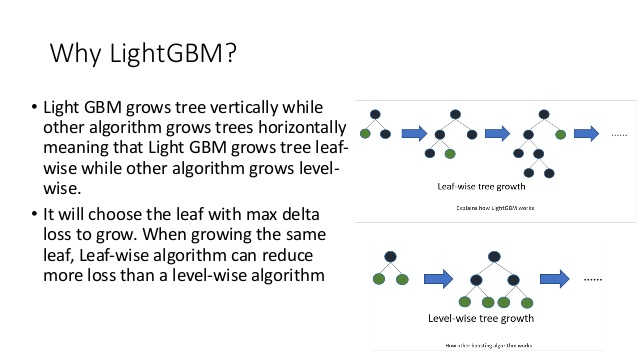

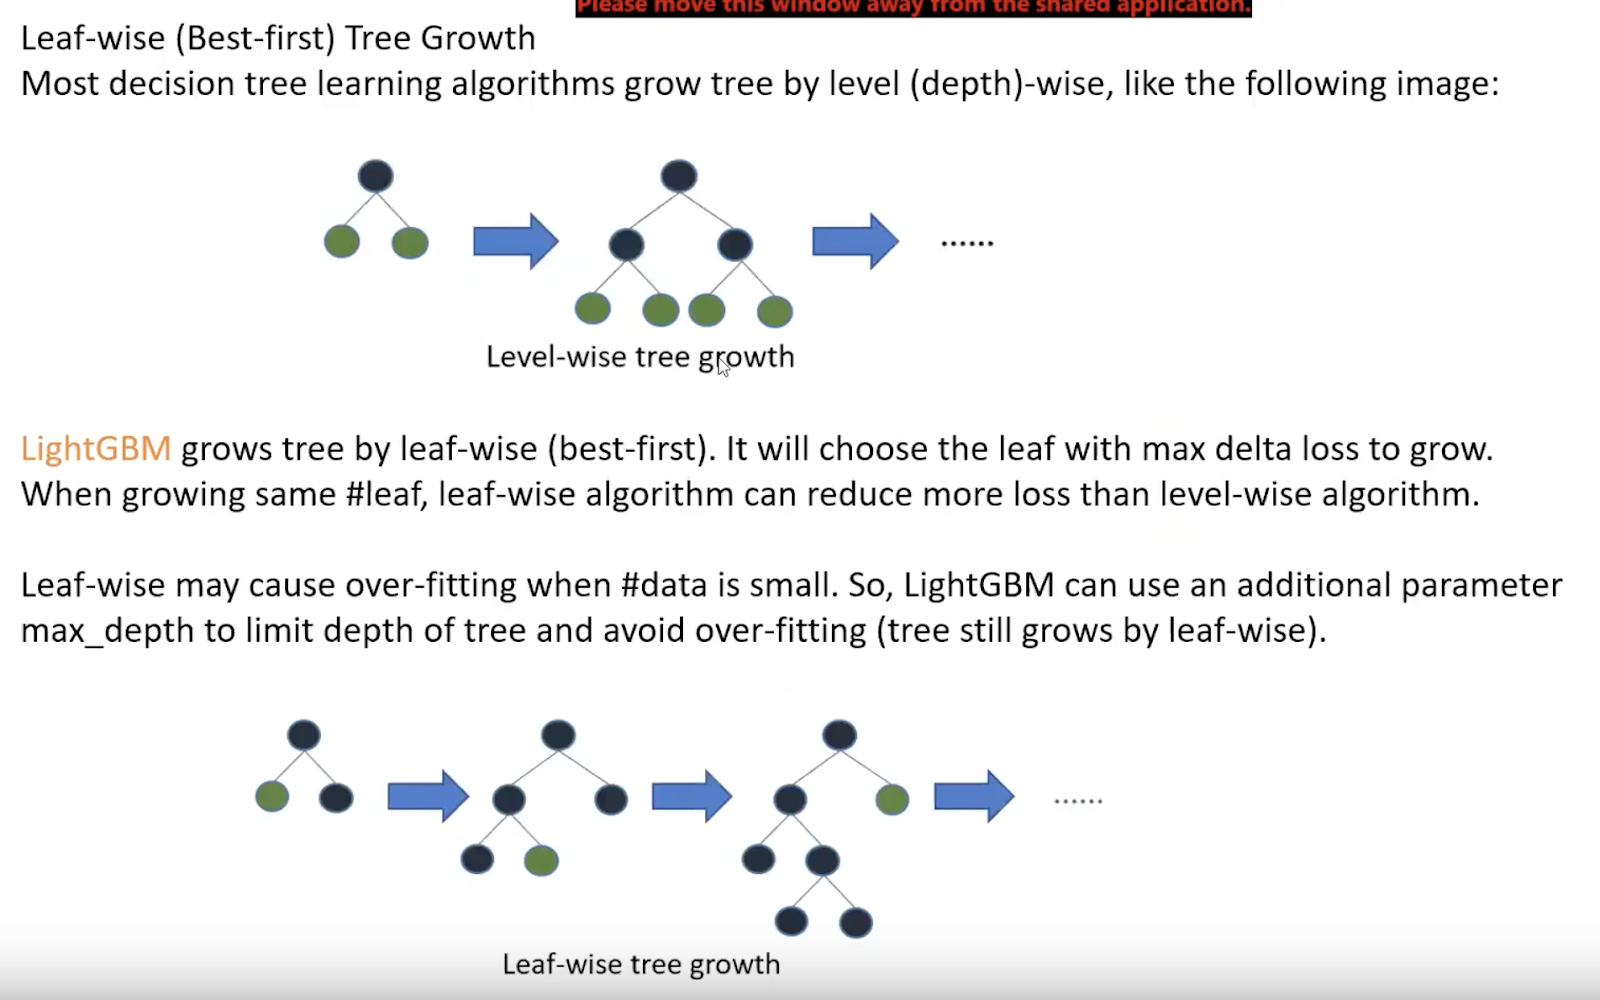

CatBoost vs. Light GBM vs. XGBoost  

See [here](https://www.kdnuggets.com/2018/03/catboost-vs-light-gbm-vs-xgboost.html)

##Install packages

In [6]:
!pip install scikit-optimize
!pip install 'scikit-optimize[plots]'

     |████████████████████████████████| 102kB 3.0MB/s 


## Call libraries

In [8]:

########################## A.Libraries ##################
## 1.0 Call needed libraries

#%reset -f              # Clear all variables
import gc
gc.collect()           # Garbage collection

# 1.1 Load pandas, numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib qt5

# Image manipulation
from matplotlib.pyplot import imshow, imsave
#from skimage.io import imshow, imsave

# 1.2 Image normalizing and compression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

# 1.3 Libraries for splitting, cross-validation & measuring performance
from sklearn.model_selection import train_test_split
# 1.3.1 Return stratified folds. The folds are made by
#        preserving the percentage of samples for each class.
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve

# 1.4 ML - we will classify using lightgbm
#          with stratified cross validation
import lightgbm as lgb

# 1.5 OS related
import os, time

# 1.6 Bayes Optimization -- One method
#  Install as:
#       pip install bayesian-optimization
#from bayes_opt import BayesianOptimization

# 1.7 Bayes optimization--IInd method
# SKOPT is a parameter-optimisation framewor
#  Install skopt as:
#       conda install -c conda-forge scikit-optimize

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


In [9]:
# 3.1
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
# 1.8 Set option to dislay many rows
pd.set_option('display.max_columns', 100)

In [11]:
## MOUNT gdrive
from google.colab import drive
drive.mount('/ashok')


Drive already mounted at /ashok; to attempt to forcibly remount, call drive.mount("/ashok", force_remount=True).


In [13]:
path = "/ashok/MyDrive/Colab_data_files/statoil/"
os.chdir(path)

In [18]:
## 2.0 Read files

trfile = 'train.json.zip'

# 2.1
#testfile = 'test.json'

# 2.2
train = pd.read_json(path+trfile)



In [19]:
################### B. Understand data ##################
################  No data processing here #############


### Define some needed functions

# 3.0 Examine any dataset
#     ExamineData.__doc__  => Gives help
def ExamineData(x):
    """Prints various data charteristics, given x
    """
    print("Data shape:", x.shape)
    print("\nColumns:", x.columns)
    print("\nData types\n", x.dtypes)
    print("\nDescribe data\n", x.describe())
    print("\nData\n", x.head(2))
    print ("\nSize of data:", np.sum(x.memory_usage()))    # Get size of dataframes
    print("\nAre there any NULLS\n", np.sum(x.isnull()))


In [20]:
# 3.1 Let us understand train data
ExamineData(train)

Data shape: (1604, 5)

Columns: Index(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'], dtype='object')

Data types
 id            object
band_1        object
band_2        object
inc_angle     object
is_iceberg     int64
dtype: object

Describe data
         is_iceberg
count  1604.000000
mean      0.469451
std       0.499222
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

Data
          id                                             band_1  \
0  dfd5f913  [-27.878360999999998, -27.15416, -28.668615, -...   
1  e25388fd  [-12.242375, -14.920304999999999, -14.920363, ...   

                                              band_2 inc_angle  is_iceberg  
0  [-27.154118, -29.537888, -31.0306, -32.190483,...   43.9239           0  
1  [-31.506321, -27.984554, -26.645678, -23.76760...   38.1562           0  

Size of data: 64288

Are there any NULLS
 id            0
band_1        0
band_2        0
inc_angle     0
is_iceberg    0
dtype: int64

In [ ]:
# 3.2 Look at the first data-point
# 3.2.1
train.columns
train['band_1'].head(3)         # Each point in the Series is a list
train['band_1'][0]              # First data point


In [ ]:
# 3.2.2
len(train['band_1'][0] )        # 5625 = 75 X 75 pixels
train['band_1'][0][:4]          # Look at first four pixel-values



In [ ]:
### Data within a band can be transfromed
### into an array and manipulated

# 3.2.3
b= train['band_1'].values          # Get complete column (of data-points)
b                                #  is transformed to array of points
                                #    And each data-point in this array
                                #     is a list.

type(b)    # numpy.ndarray


In [ ]:
# 3.2.4
b.shape    # So how many lists: 1604

# 3.2.5
j = 5                           # Get jth list
b[j]                            # Look at the jth list or data-point in array
b[j][:4]                        # Within the jth list (data-point), look at
                                #  Ist four pixel values



In [ ]:
# 3.3 How many values this data-point has
#len(train['band_1'][0])     # 5625 : 75 X 75


# 3.4 Plot the image contained at the first data-point
img0 = b[0]
type(img0)                     # list
img0 = np.array(img0)          # array
g = img0.reshape(75,75)        # Same as: np.array(b[0]).reshape(75,75)
imshow(g)
plt.show()



In [ ]:
################### C. Define useful functions ##################
################  No data processing here #############


# 4.0 Expand each data-point of band_1/band_2 into
#     an array of 5625 points
#     For 1604 rows, we get a matrix of size
#     1604 X 5625

def transform_band_to_matrix(df, band_name):
    """df: A dataframe
       band_name: which of the two bands
    """
    # 4.1 An array of lists. Each point in the array
    #     is a list
    b =   df[band_name].values
    # 4.2 Create a zero-filled-matrix of size
    #     1604 X 5625 images
    #     Each row of matrix will hold one image
    #     from the band
    x = np.zeros((1604, 5625))  # 1604 X 5625
    # 4.3 For every row-point
    for j in range(1604):
        # 4.4 For every jth list in 'b' ie b[j]
        #     Populate jth row of x, x[j,],
        #     with all elements of list b[j]
        jth_list = b[j]    # jth point of array is a list
        #    Try:  y=[1,2,3] ; np.array(y)
        x[j, :] = np.array(jth_list)
    return(x)

In [ ]:
"""
Why have a zero filled array:
=============================
    An alternative way of creating
    a matrix 1604 X 5625 is:
        a. Get b[0] & b[1]
        b. Transform both of them to array
            as, np.array(b[0])
        c. Vertically stack them using np.vstack
        d. Then get b[3]. Stack it under
           earleir stack

    But such stacking is not gauranteed to give
    a matrix with adjacent memory locations

"""


In [ ]:
# 5.0 Given a matrix of 1605 X 5625 from above function,
#     plot first six images after reshaping each row
#     (or flattened) array to 75 X 75. That is plot
#     x[0], x[1], ...x[5] after reshaping each
#     to 75 X 75
def plot_first_six_Images(x):
    """x: matrix of size 1604 X 5625
       Given a image matrix with each row
       as an image, plot images in Ist
       six rows.
    """
    # 5.1 Create figure-window and axes
    _, ax = plt.subplots(nrows = 2, ncols= 3)
    # 5.2
    ax[0,0].imshow(x[0, :].reshape(75,75))
    ax[0,1].imshow(x[1, :].reshape(75,75))
    ax[0,2].imshow(x[2, :].reshape(75,75))
    ax[1,0].imshow(x[3, :].reshape(75,75))
    ax[1,1].imshow(x[4, :].reshape(75,75))
    ax[1,2].imshow(x[5, :].reshape(75,75))
    plt.show()



In [ ]:
# 6.0 Save an one image file to disk just to look at its size
def SaveOneImg(x, filename):
    """x is matrix of row-wise images
       Each image in one row
       There are as many images as there are rows
       Saves just one image in the very first row
       Returns saved file size
    """
    # 6.1 Min and Max pixel intensity values
    #     in the first row
    lower = np.min(x[0,:])
    upper = np.max(x[0,:])
    # 6.2 Range of values
    range = upper - lower
    # 6.3 Normalize now
    trans = (x[0,:] - lower)/range           # Normalize image to values [0,1]
    imsave(filename, trans.reshape(75,75))   # Reshape image and save it to disk
    return os.path.getsize(filename)         # Return img size on disk



In [ ]:
# 7.0 Singular value decomposition of
#     of matrix 1604 X 5625
#     So we have 5625 columns
#     See SVD vs PCA below
def SingularValueDecomp(x, n_comp):
    """x is a matrix of images
         or a dataset with 5625 columns
         It is returned from function:
         transform_band_to_matrix().
       n_comp: Number of SVD components
       This function returns three objects:
         a. transformed matrix,
         b. transformation object, and
         c. explained variance
    """
    # 7.1 Create an object to perform SVD
    svd = TruncatedSVD(n_components = n_comp)
    # 7.2 Fit and transform
    g = svd.fit_transform(x)
    # 7.3 % of variance explained by each component
    ev1 = svd.explained_variance_ratio_
    # Return a tuple of three values
    return (g, svd, ev1)


In [ ]:

################### D. Data processing ################

# 9.0 There are some 'na' values in 'inc_angle' column
#     We will fill these up with mean value. Note
#     that the word 'na' is string not np.nan

# 9.1 Following is a pandas Series with boolean values
train['inc_angle'] == 'na'



In [ ]:

# 9.2 How many such rows are there?
np.sum(train['inc_angle'] == 'na')   # 133 only



In [ ]:
# 9.3 OK. Get now the mean of non-na rows
m_value = np.mean(train.loc[train['inc_angle'] != 'na', 'inc_angle' ])
m_value       # 39.26870747790618


In [ ]:

# 9.4 Replace 'na' with mean-value
train.loc[train['inc_angle'] == 'na', 'inc_angle' ] = m_value


In [ ]:
# 9.5 Finally check
train['inc_angle']


In [ ]:
# 9.6 Create a categorical variable from inc_angle
train['c_angle'] = 1
train.loc[train['inc_angle'] > m_value, 'c_angle'] = 2


In [ ]:
################### E. Pre Analyses  ##################


### Our steps in Modeling
##  Brief steps: ################
#   1. Reshape single column, band_1, into an array 5625 columns
#   2. Reshape single column, band_2, into 5625 columns
#   3. Truncate 5625 cols of band_1 to 25 cols using SVD
#   4. Truncate 5625 cols of band_2 to 25 cols using SVD
#   5. Concatenate two expanded column. Result: 50 cols
#   6. Cut inc_angle into two, to create a categorical
#      variable having two categories
#   7. To (5) above, concatenate two morecolumns:
#      One: of 'inc_angle' and Two: categorical column
#      created in step (6)
#   8. Do modeling
#   9. While modeling tune parameters of model using Bayes
#      optimization technique
################


In [ ]:
# 10.0 Examine train/test data
ExamineData(train)    # 1604 X 5   155MB
# 10.1
#ExamineData(test)     # 8424 X 5   817MB



In [ ]:
## 11. Popualte a variable with flattened images
#      from band_1.
#      Band 1 and Band 2 are signals characterized
#      by radar backscatter produced from different
#      polarizations at a particular incidence angle.
matrix_band1 = transform_band_to_matrix(train, "band_1")
matrix_band1.shape           # 1604 X 5625
# 12 Also plot six of the satellite images
plot_first_six_Images(matrix_band1)



In [ ]:
## 13. Popualte another variable with flattened images from band_2
matrix_band2 = transform_band_to_matrix(train, "band_2")
matrix_band2.shape


In [ ]:

# 13.1 Also plot six images from it
plot_first_six_Images(matrix_band2)



In [ ]:

# 13.1 Also plot six images from it
plot_first_six_Images(matrix_band2)



In [ ]:

## 14. Save one image from band1 into a file
#      Returned value is file size
filesize = SaveOneImg(matrix_band1, "band1.jpg")
filesize                # 1695 bytes




In [ ]:

# 15. Perform Singular Value Decomposition
#    Get how much variance is explained per-component
#    in band1. Start with total of 500 components
_,_,ev1 = SingularValueDecomp(matrix_band1, 500)
_,_,ev2 = SingularValueDecomp(matrix_band2, 500)



In [ ]:

# 16. Plot the cumulative sum of explained variances
#     component-wise for both the bands
plt.figure()
frac_band1 = np.cumsum(ev1)
frac_band2 = np.cumsum(ev2)
plt.plot(frac_band1[:200])         # 25 components appear OK
plt.plot(frac_band2[:200])         # 25 components appear OK
plt.show()


In [ ]:

# 17. Next, let us , therefore, truncate to 25 components
#     Singular value decomposition of two bands of train data
#      So new flattened images are in comp1 and in comp2
comp1,svd1, _ = SingularValueDecomp(matrix_band1,25)
comp2,svd2, _ = SingularValueDecomp(matrix_band2, 25)



In [ ]:

# 18. We can perform inverse_transform with just 25 svd components
#     and relook at images (75 X 75) to visually see how much of
#     information relating to original image does exist
im1 = svd1.inverse_transform(comp1)
im2 = svd2.inverse_transform(comp2)
im1.shape         # Shape remains as 1604 X 5625, as earlier
im2.shape



In [ ]:

# 19. Now, relook at transformed and original images
#     Transformed first
plot_first_six_Images(im1)
# 19.1 Compare above with original. Not bad..
plot_first_six_Images(band1)



In [ ]:

## 20. Does SVD compress image?
##     Save transformed image
#      And compare its size with that of original image
#      saved earlier
##     Obviously SVD compresses image
SaveOneImg(im1, "im1.jpg")      # Size: 713 bytes as against 1695 bytes



In [ ]:

################### F. Modeling  ##################

### 21. Finally we horizontally stack flattened images
#       Note here that comp1 and comp2 may be at
#       difft memory locations.
X = np.hstack((comp1, comp2))
X.shape
X[0]     # Check Ist row
X[:2]    # Check Ist two rows


# 21.1 Also stack inc_angle
X.shape         # 1604 X 50
X = np.hstack((X, train.inc_angle.values.reshape(X.shape[0],1)))
X.shape          # (1604,51)
X = np.hstack((X, train.c_angle.values.reshape(X.shape[0],1)))
X.shape      # 1604 X 52                Predictors

X[0]         # Check again Ist row
X[:2]       # Check again Ist two rows

y = train['is_iceberg'].values         # Target


# 21.2 Partition into train/test
X_train, X_test, y_train, y_test = train_test_split(
                                     X, y,
                                     test_size=0.30,
                                     random_state=42
                                     )


###############################################################################
################# Bayesian optimization-I with skopt ##########################
# Refer:
# https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769
# Refer for LGBMRegressor:
#   https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMRegressor
# And  https://lightgbm.readthedocs.io/en/latest/Parameters.html

# Our modeling object for Classification
# Can be any modeler: RandoForest, xgboost, neuralnetwork
#                     svm etc

# 22. Store train and test data in lightgbm,
#     Dataset object


model = lgb.LGBMRegressor(                # Regressor will also perform classification
                          objective='binary',
                          metric='auc',   # This output must match with what
                                          #  we specify as input to Bayesian model
                          n_jobs=2,
                          verbose=0
                          )

# 22.1 Parameter search space for selected modeler
#      For suggested parameter grid for lightgbm, pl see: 
#         https://github.com/Microsoft/LightGBM/issues/695
#
params = {
        'boosting' :   Categorical(['gbdt','rf','dart']),
        'n_estimators': Integer(50, 100),  # Number of boosted trees or iterations to fit (default: 100).

        'num_leaves':   Integer(5,45),     # Maximum tree leaves for base boosters
                                           # Create a node only if no of leaves exceed this limit
                                           #  and also following condition of 'min_child_samples' is met

        'min_child_samples': Integer(1, 50),  # Create a node only if min data-points at this node
                                              #  exceed this limit

        'feature_fraction': Real(0.1, 0.9),	   # Randomly select part of features on each iteration
                                               #  for every boosted tree

        'bagging_fraction': Real(0.8, 1),	   # Randomly select part of data without resampling
                                               #   for each boosted tree

        'bagging_freq'   : Integer(1,10),      # k means perform bagging at every k iteration

        'max_depth' : Integer(1, 50),          # Maximum tree depth for base learners, -1 means no limit.

        'learning_rate': Real(0.01, 1.0, 'log-uniform'), # Prob of interval 1 to 10 is same as 10 to 100
                                                         # Equal prob of selection from 0.01 to 0.1, 0.1
                                                         # to 1
                                                         # In a loguniform distributon, log-transformed
                                                         # random variable is uniformly distributed

        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),  # L2 regularization term on weights.
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),    #  L1 regularization


        'scale_pos_weight': Real(1, 10),       # default: 1
                                               # used only in binary application
                                               # How much more importance should be given to binary
                                               # weight of labels with positive class


        #-----***** Not understood **** -----

        'max_bin': Integer(100, 1000),        # max number of bins that feature
                                              #  values will be bucketed in
                                              # small number of bins may reduce
                                              # training accuracy but may increase
                                              # general power (deal with over-fitting)

        'min_child_weight': Real(1, 10),      # Deals with overfitting

        'subsample_for_bin': Integer(100000, 500000)  #  Number of samples for constructing bins(default: 200000)
                                               # setting this to larger value will give better training
                                               #  result, but will increase data loading time


        }


# 22.2 Cross validation strategy for the modeler
#      Perform startified k-fold cross-validation
#      There is also RepeatedStratifiedKFold() class
#      that will repeat startified k-fold N-number
#      of times
#      Instantiate cross-vlidation object
"""
Examples of Cross-validation strategies:
    i)   Leave one out  : Very time consuming
    ii)  Leave P out    : For example, leave 2 out
    iii) kfold          : k-equal random folds
    iv)  StratifiedKFold : kfolds + stratification
    v)   ShuffleSplit  => Generate n-numbers of userdefined pairs
                          of (train,test). For examples, in each
                          (train,test) pair, let number of rows
                          of 'test' data be 30% of train data

"""

cvStrategy = StratifiedKFold(
                             n_splits=3,
                             shuffle=True,
                             random_state=42
                            )



# 22.3 Bayesian object instantiation
#     For API, refer: https://scikit-optimize.github.io/#skopt.BayesSearchCV
#     For example: https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html
bayes_cv_tuner = BayesSearchCV(
                              estimator = model,    # rf, lgb, xgb, nn , pipeline etc--Black box
                              search_spaces = params,  # Specify params as required by the estimator
                              scoring = 'roc_auc',  # Input to Bayes function
                                                    # modeler should return this
                                                    # peformence metric
                              cv = cvStrategy,      # Optional. Determines the cross-validation splitting strategy.
                                                    #           Can be cross-validation generator or an iterable,
                                                    #           Possible inputs for cv are: - None, to use the default 3-fold cv,
                                                    #           - integer, to specify the number of folds in a (Stratified)KFold,
                                                    #           - An object to be used as a cross-validation generator.
                              n_jobs = 2,           # Start two parallel threads for processing
                              n_iter = 50,        # How many times to look for parameter sets
                              verbose = 1,
                              refit = True,       #  Refit the best estimator with the entire dataset
                              random_state = 42
                               )

# 22.4 Start learning using Bayes tuner
start = time.time()
result = bayes_cv_tuner.fit(
                           X_train,       # Note that we use normal train data
                           y_train       #  rather than lgb train-data matrix
                           #callback=status_print
                           )

end = time.time()
(end - start)/60


# 22.5 So what are the results?
#      Use the following estimator in future
bayes_cv_tuner.best_estimator_
# 22.6 What parameters the best estimator was using?
best_params = pd.Series(bayes_cv_tuner.best_params_)
best_params

# 22.7 Best auc score for the above estimator
np.round(bayes_cv_tuner.best_score_, 4)

# 22.8 Summary of all models developed by Bayes process
allModels_summary = pd.DataFrame(bayes_cv_tuner.cv_results_)
allModels_summary.shape  # 50 X 26
allModels_summary.head()


### 23. Let us now use the best estimator
bst_bayes = bayes_cv_tuner.best_estimator_
bst_bayes
# 23.1 Train the best estimator
bst_bayes.fit(X_train, y_train)
# 23.2 Make predictions
pred = bst_bayes.predict(X_test)
pred

# 23.3 So what is auc score
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
auc(fpr, tpr)    # 94%


############## Learning Curve with lightgbm #############
## What is a Learning Curve--See note at the end.

# Ref: https://lightgbm.readthedocs.io/en/latest/Python-API.html#training-api
# 24. Store train and test data in lightgbm,
#     Dataset object


d_train = lgb.Dataset(X_train, label=y_train) # transformed train data
d_test = lgb.Dataset(X_test, label = y_test)  # test data

# 24.1 Watch error in these datasets as
#      modeling proceeds
watchlist = [d_train, d_test]

## 25. Build Lightgbm model
# Set parameters first
# Ref: http://lightgbm.readthedocs.io/en/latest/Python-Intro.html
#      https://lightgbm.readthedocs.io/en/latest/Parameters.html

params = { 'learning_rate': 0.25,
           'verbosity': -1,             # Be verbose when processing
           'categorical_feature' : [51],  # which cols are categorical
                                          # (specify index 0,1,2..)
            'nthread': 4,                 # USe CPU cores
            'max_depth': 7,            # limit the max depth for tree model
            'objective' : "binary",
            'metric' : ['auc', 'binary_logloss']
           }


## 26
start = time.time()
# 26.1
evals_result = {} # to record eval results for plotting
model = lgb.train(params,
                  train_set=d_train,
                  num_boost_round=1500,     # 1000 residuals are mapped to functions
                                            #   successively
                  valid_sets=watchlist,
                  early_stopping_rounds=100, # The goal of early stopping is to
                                            #  decide if any of the latest X rounds
                                            #  has improved performance versus a baseline,
                                            #  according to some metric.
                                            # The model will train until the validation
                                            #  score stops improving. Validation error
                                            #  needs to improve at least every
                                            #  early_stopping_rounds to continue training.
                 evals_result=evals_result, # Record evaluation results for plotting
                 verbose_eval=10
                 )

# 26.2
end = time.time()
end - start

# 27. Plot learning curve
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()


# 28. Plot precision/Recall curve
#  Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
from sklearn.metrics import precision_recall_curve as pr
y_pred = model.predict(X_test)
precision,recall,_ = pr(y_test,y_pred)   # Reruns a tuple of three arrays
                                         # precision, recall, thresholds
plt.plot(precision,recall)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()



######## FEATURE IMPORTANCE ###########

# 29
# Column wise imporatnce. Default Criteria: "split".
# "split":  Result contains numbers of times feature is used in a model.
# “gain”:   Result contains total information-gains of splits
#           which use the feature
print('Plot feature importances...')
ax = lgb.plot_importance(bst_bayes, max_num_features=10)
ax.tick_params(labelsize=20)
plt.show()

# 29.1 Does not work. Needs 'graphviz'
ax= lgb.plot_tree(bst_bayes,
                  tree_index=9,
                  figsize=(40, 20),
                  show_info=['split_gain'])

plt.show()




#################### Bayesian-optimization-II Normal method ###################
# Ref: https://github.com/fmfn/BayesianOptimization

# 25. Create lightgbm dataset, a binary file
#     LightGBM binary file
#     Also saving Dataset into a LightGBM binary file will make loading faster:
d_train = lgb.Dataset(X_train, label=y_train) # transformed train data
d_test = lgb.Dataset(X_test, label = y_test)  # test data


# 25.1
#  Step 1: Create a function that when passed some parameters
#          evaluates results using cross-validation
def lgb_eval(num_leaves,feature_fraction, bagging_fraction,max_depth):
    # Specify complete list of parameters: static and dynamic
    # 25.2 Static: Parameters that need not be modified
    params = {'application':'binary',
              'num_boost_round':4000,
              'learning_rate':0.05,
              'early_stopping_round':100,
              'metric':'auc',
              'shuffle':True
              }

    # 25.3 Dynamic: Parameters that would be passed using arguments to function
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['max_depth'] = int(round(max_depth))

    # 25.4 Now evaluate with above parameters
    cv_result = lgb.cv(params,
                       d_train,
                       nfold=4,
                       seed=0,
                       stratified=True,
                       #verbose_eval =200,
                       metrics=['auc'])

    # 25.5 Finally return maximum value of result
    return max(cv_result['auc-mean'])


# 26. Step 2: Define BayesianOptimization function has
#             two arguments
lgbBO = BayesianOptimization(
                             lgb_eval,               # Which function will evaluate

                             # Parameters to tune and to be
                             #   passed to above function
                             # Specify parameter range for each
                             {'num_leaves': (24, 45),
                              'feature_fraction': (0.1, 0.9),
                              'bagging_fraction': (0.8, 1),
                              'max_depth': (5, 8.99)
                              }
                             )

# 26.1. Gaussian process parameters
gp_params = {"alpha": 1e-5}      # Initialization parameter for gaussian
                                 # process

# 27. Step 3: Start optimization
start = time.time()
lgbBO.maximize(init_points=2,    # Number of randomly chosen points to
                                 # sample the target function before
                                 #  fitting the gaussian Process (gp)
                                 #  or gaussian graph
               n_iter=25         # Total number of times the
                                 #   process is to repeated
               )
end = time.time()
f"Minutes: {(end -start)/60}"



# 28. Get results
lgbBO.max
lgbBO.max['params']['max_depth']
lgbBO.max['params']['bagging_fraction']
lgbBO.max['params']['feature_fraction']
lgbBO.max['params']['num_leaves']

# 29. Newly discovered parameter values
params_new = lgbBO.max['params']
params_new['num_leaves'] = int(params_new['num_leaves']) + 1
params_new['max_depth'] = int(params_new['max_depth']) + 1


# 29.1 Objective alias 'application'
params_new['objective'] = ['binary']    # Default regression

# 29.2 Metric parameters
params_new['metric'] = ['auc', 'binary_logloss']   # Multiple loss parameters


# 29.3 Watch error in these datasets as
#      modeling proceeds
watchlist = [d_train, d_test]


# 30
start = time.time()
model = lgb.train(params_new,
                  train_set=d_train,
                  num_boost_round=1000,     # 1000 residuals are mapped to functions
                                            #   successively
                  valid_sets=watchlist,
                  early_stopping_rounds=20, # The goal of early stopping is to
                                            #  decide if any of the latest X rounds
                                            #  has improved performance versus a baseline,
                                            #  according to some metric.
                                            # The model will train until the validation
                                            #  score stops improving. Validation error
                                            #  needs to improve at least every
                                            #  early_stopping_rounds to continue training.
                  evals_result=evals_result, # Record evaluation results for plotting
                  verbose_eval=10)


end = time.time()
end - start

# 30.1
model.best_score

# 30.2 Save model to a text file for later use
model.save_model('model.txt',
                 num_iteration=model.best_iteration
                 )

# 30.3 Delete model
del model

# 30.4 Load back saved model
bst = lgb.Booster(model_file='model.txt')  #init model

# 30.5 If early stopping is enabled during training,
#      get predictions from the best iteration with
#      bst.best_iteration

lgb_pred = bst.predict(X_test,
                       num_iteration=bst.best_iteration)  > 0.5
lgb_pred
y_test

# 30.6 Now accuracy
np.sum(lgb_pred == y_test)/y_test.size
# 30.7 So what is auc score
fpr, tpr, thresholds = roc_curve(y_test, lgb_pred, pos_label=1)
auc(fpr, tpr)



#####################################################
################ SVD vs PCA ###################
"""
Ref:
   https://stats.stackexchange.com/a/87536/78454

SVD is slower than PCA but is often considered to be the preferred
method because of its higher numerical accuracy.
As you state in the question, principal component analysis (PCA) can
be carried out either by SVD of the centered data matrix X.

Matlab's help records this:
Principal component algorithm that pca uses to perform the
principal component analysis [...]:
[PCA uses two methods, svd and eigenvalue BUT unlike in SVD
PCA is done (on column-wise) centered data]



 i)    'svd' -- Default. Singular value decomposition (SVD) of X.
                         Slower but more accurate
 ii)   'eig' -- Eigenvalue decomposition (EIG) of the covariance matrix.
                The EIG algorithm is faster than SVD when the number of
                observations, n, exceeds the number of variables, p, but
                is less accurate because the condition number of the
                covariance is the square of the condition number of X.
                Faster but less accurate


"""

"""
Learning Curve--General definition
Ref: https://stackoverflow.com/a/13715276

    One line:  How a model performs as some hyperparameter is varied

    A learning curve conventionally depicts improvement in performance
    on the vertical axis when there are changes in another parameter
    (on the horizontal axis), such as training set size (in machine learning)
    or iteration/time (in both machine and biological learning). One salient
    point is that many parameters of the model are changing at different points
    on the plot.

    """
###############################
